In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import re
import numpy as np

from matplotlib.ticker import AutoMinorLocator

Paths to the files for easy access

In [2]:
terminal_paths = ["../logs/180725/edge/base/t5-small_20250718_000333_terminal.log",
                    "../logs/180725/edge/baseft/SAMSUM_t5-small_20250718_004415_terminal.log",
                    "../logs/180725/edge/pruneft/SAMSUM_nash_unif_0.3_3_20250718_012347_terminal.log"]

tegrastats_paths = ["../logs/180725/edge/base/t5-small_20250718_000333_tegrastats.log",
                    "../logs/180725/edge/baseft/SAMSUM_t5-small_20250718_004415_tegrastats.log",
                    "../logs/180725/edge/pruneft/SAMSUM_nash_unif_0.3_3_20250718_012347_tegrastats.log"]



base_model_path = "../logs/180725/2025-07-18 00_03_54.638907_latency_metrics.csv"
ft_model_path = "../logs/180725/2025-07-18 00_44_38.251615_latency_metrics.csv"
prune_model_path = "../logs/180725/2025-07-18 01_24_15.839388_latency_metrics.csv"

# Latency

Load DF

In [3]:
base_df = pd.read_csv(base_model_path)
ft_df = pd.read_csv(ft_model_path)
prune_df = pd.read_csv(prune_model_path)

In [4]:
# Combine dataframes
df_latency = [base_df, ft_df, prune_df]# Concatenate all dataframes into one

In [5]:
df_latency[1].head()

,TTFT (s),TGT (s),TPOT (s),TPS,gen_len
0,0.086260,0.389186,0.383422,41.729491,16
1,0.062476,0.678162,0.669789,40.311224,27
2,0.077896,0.747271,0.738288,39.280088,29
3,0.046153,0.395672,0.389447,38.516107,15
4,0.084342,1.540943,1.523579,39.380952,60


Rename DF

In [6]:
for dataframe in df_latency:
    # Rename columns
    renamed_columns = {
        "TTFT (s)": "TTFT (ms)",
        "TGT (s)": "TGT (ms)",
        "TPOT (s)": "TPOT (ms)",
        "TPS" : "TPS (token/s)",
    }
    dataframe.rename(columns=renamed_columns, inplace=True)

    # Convert seconds to milliseconds
    columns_to_multiply = ["TTFT (ms)", "TGT (ms)", "TPOT (ms)"]
    dataframe[columns_to_multiply] = dataframe[columns_to_multiply] * 1000  # Convert to milliseconds

ITL Calculations

In [7]:
base_df.head()

,TTFT (ms),TGT (ms),TPOT (ms),TPS (token/s),gen_len
0,81.533909,655.729807,648.545616,41.631613,27
1,46.412078,1252.937291,1241.465864,39.469470,49
2,71.776201,1250.691541,1239.023411,39.547275,49
3,61.852451,1621.895649,1607.847189,39.804778,64
4,95.672563,1640.732093,1624.753170,39.390599,64


In [8]:
for dataframe in df_latency:
    dataframe["ITL (ms/token)"] = (dataframe["TGT (ms)"] - dataframe["TTFT (ms)"]) / (dataframe["gen_len"] - 1)


In [9]:
base_df.head()

,TTFT (ms),TGT (ms),TPOT (ms),TPS (token/s),gen_len,ITL (ms/token)
0,81.533909,655.729807,648.545616,41.631613,27,22.084458
1,46.412078,1252.937291,1241.465864,39.469470,49,25.135942
2,71.776201,1250.691541,1239.023411,39.547275,49,24.560736
3,61.852451,1621.895649,1607.847189,39.804778,64,24.762590
4,95.672563,1640.732093,1624.753170,39.390599,64,24.524754


Remove Outliar

In [41]:
base_df = base_df[base_df["TTFT (ms)"] <= 400]

Combine DF

In [42]:
combined_df = pd.concat([base_df, ft_df, prune_df], keys=["Base", "FT", "Prune"], names=["Model"])
combined_df.head()

TTFT (ms)     TGT (ms)    TPOT (ms)  TPS (token/s)  gen_len  \
Model                                                                  
Base  0  81.533909   655.729807   648.545616      41.631613       27   
      1  46.412078  1252.937291  1241.465864      39.469470       49   
      2  71.776201  1250.691541  1239.023411      39.547275       49   
      3  61.852451  1621.895649  1607.847189      39.804778       64   
      4  95.672563  1640.732093  1624.753170      39.390599       64   

         ITL (ms/token)  
Model                    
Base  0       22.084458  
      1       25.135942  
      2       24.560736  
      3       24.762590  
      4       24.524754

Histrogram of Latency Metrics

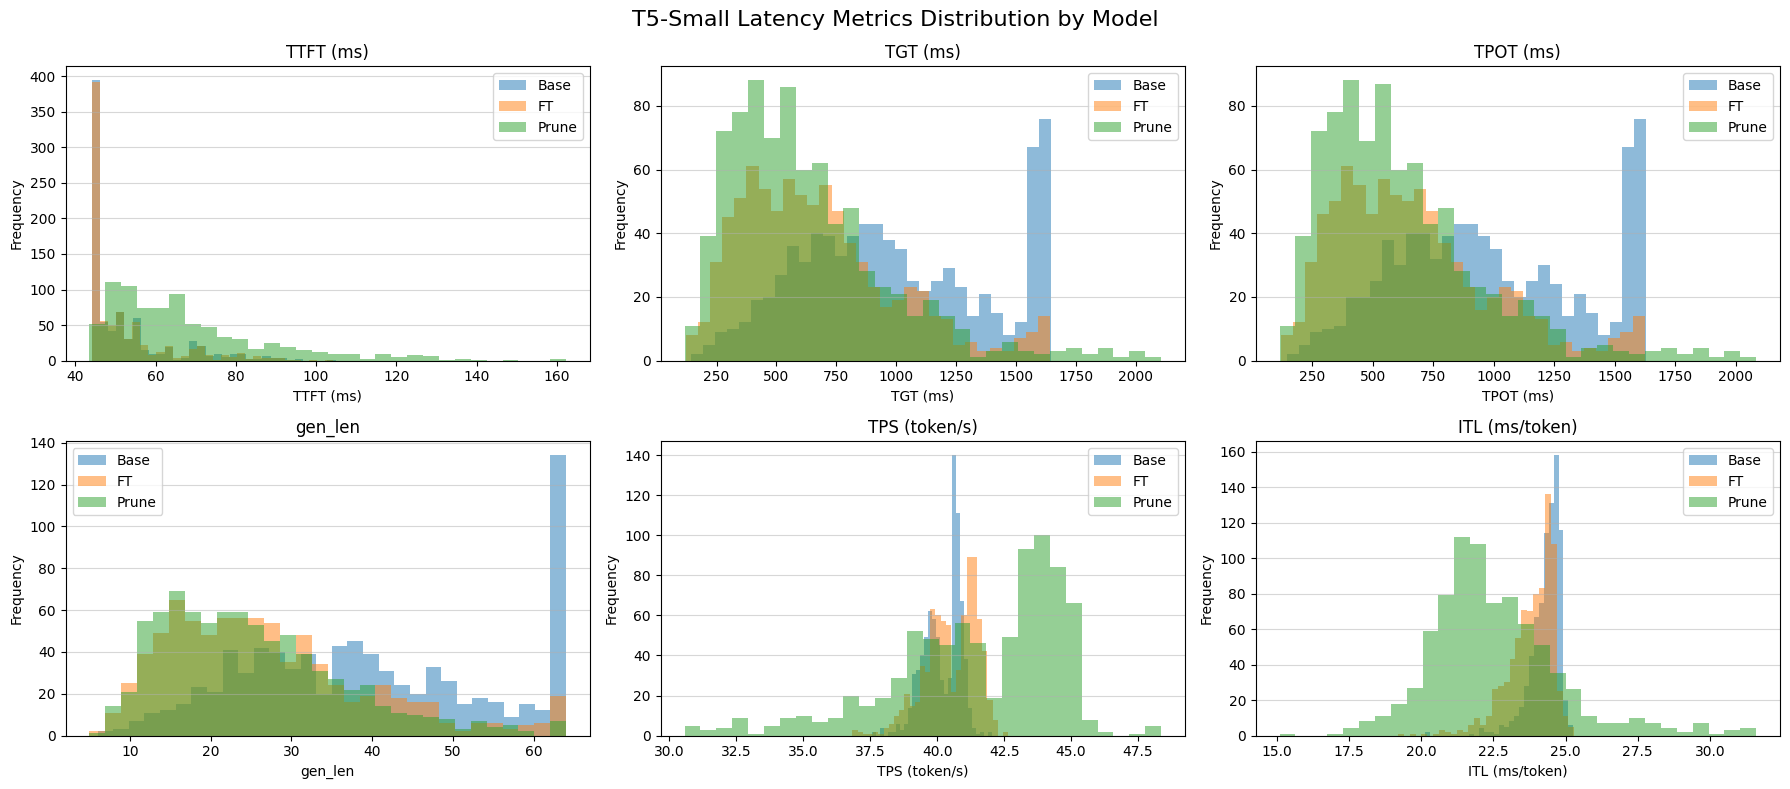

In [59]:
# Create one big figure with 2x3 subplots for each latency column (distribution by model)
latency_columns = ["TTFT (ms)", "TGT (ms)", "TPOT (ms)", "gen_len", "TPS (token/s)", "ITL (ms/token)"]
fig, axes = plt.subplots(2, 3, figsize=(18, 8))

for idx, col in enumerate(latency_columns):
    row = idx // 3
    col_idx = idx % 3
    ax = axes[row, col_idx]
    for model in combined_df.index.levels[0]:
        combined_df.loc[model][col].plot(kind="hist", bins=30, alpha=0.5, ax=ax, label=model)
    ax.set_title(f"{col}")
    ax.set_xlabel(col)
    ax.set_ylabel("Frequency")
    ax.grid(which='major', axis='y', linestyle='-', alpha=0.5)
    ax.legend()

# Hide the empty subplot if columns < 6
if len(latency_columns) < 6:
    axes[1, 2].axis('off')

plt.suptitle("T5-Small Latency Metrics Distribution by Model", fontsize=16)
plt.tight_layout()
plt.show()

Mean Values Bar Graph

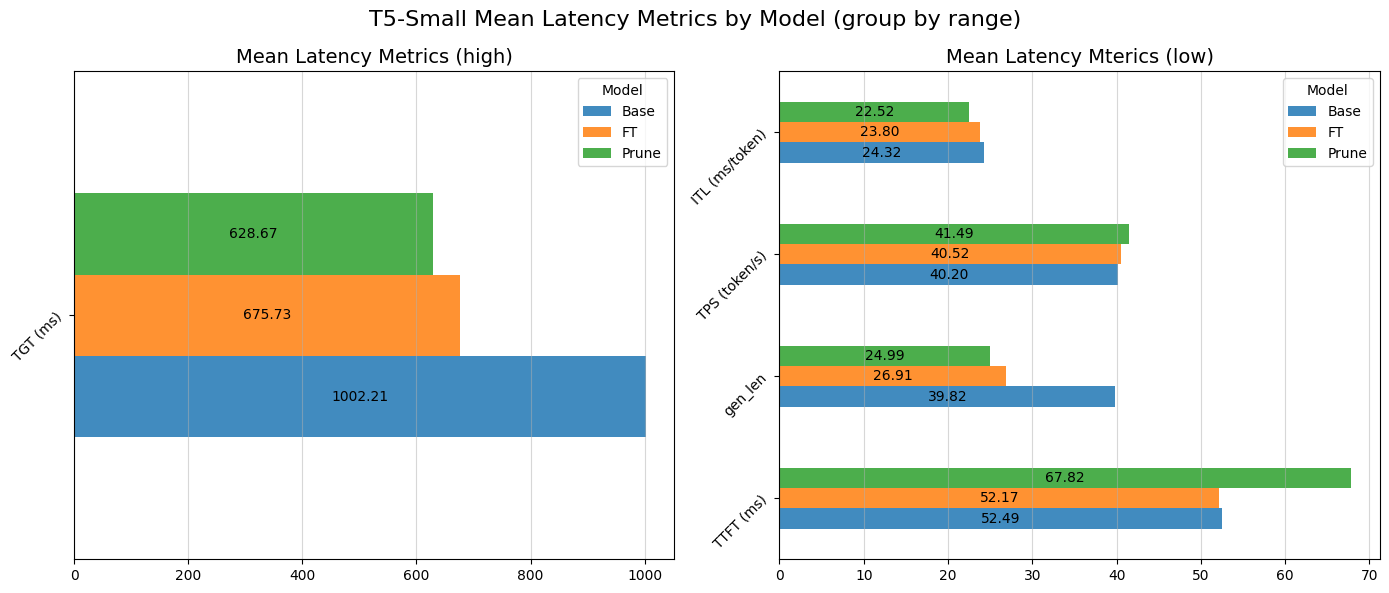

In [58]:
# Plot all metrics as grouped bar chart (models side by side for each metric), transposed
latency_columns = ["TGT (ms)"]
perf_columns = ["TTFT (ms)", "gen_len", "TPS (token/s)", "ITL (ms/token)"]
mean_values = []

latecy_mean_values = combined_df.groupby("Model")[latency_columns].mean()
mean_values.append(latecy_mean_values)

perf_columns_mean_values = combined_df.groupby("Model")[perf_columns].mean()
mean_values.append(perf_columns_mean_values)

fig, ax = plt.subplots(1, 2, figsize=(14, 6))
for i in range(len(mean_values)):
    mean_values[i].T.plot(kind="barh", ax=ax[i], legend=True, alpha=0.85)
    ax[i].grid(which='major', axis='x', linestyle='-', alpha=0.5)
    ax[i].tick_params(axis='y', labelrotation=45)
    for container in ax[i].containers:
        ax[i].bar_label(container, fmt='%.2f', label_type='center')

ax[0].set_title("Mean Latency Metrics (high)", fontsize=14)
ax[1].set_title("Mean Latency Mterics (low)", fontsize=14)

plt.suptitle("T5-Small Mean Latency Metrics by Model (group by range)", fontsize=16)
plt.tight_layout()
plt.show()

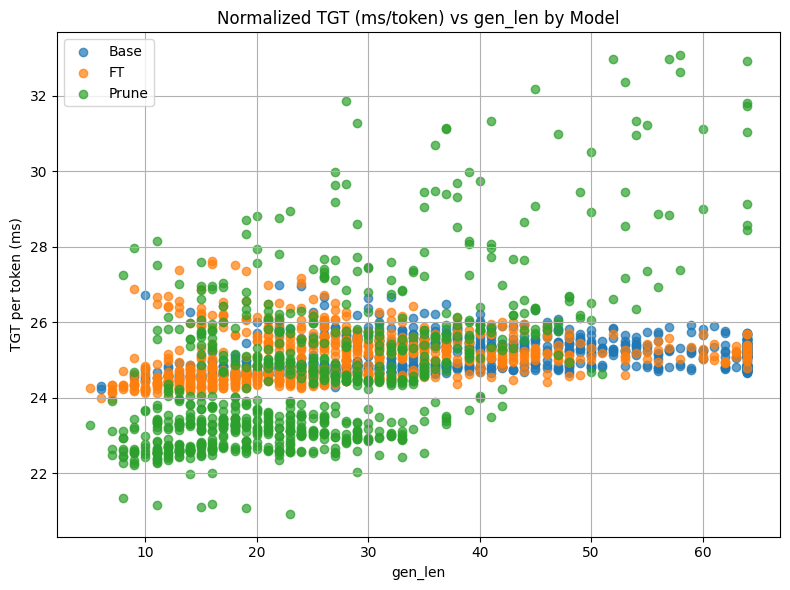

In [45]:
combined_df["TGT_per_token"] = combined_df["TGT (ms)"] / combined_df["gen_len"]

fig, ax = plt.subplots(figsize=(8, 6))
for model in combined_df.index.levels[0]:
    model_df = combined_df.loc[model]
    ax.scatter(model_df["gen_len"], model_df["TGT_per_token"], label=model, alpha=0.7)

ax.set_xlabel("gen_len")
ax.set_ylabel("TGT per token (ms)")
ax.set_title("Normalized TGT (ms/token) vs gen_len by Model")
ax.legend()
ax.grid(True)

plt.tight_layout()
plt.show()

# Hardware Usage

Get values from tegrastats log files

In [46]:
def tegrastats_log_to_df(logfile):
        """
        Parse a tegrastats log file and return a pandas DataFrame with all relevant metrics.
        """

        timestamps, ram_used, ram_total, swap_used, swap_total, cpu_avg, gr3d_freq = [], [], [], [], [], [], []
        cpu_temp, gpu_temp, soc0_temp, soc1_temp, soc2_temp, tj_temp = [], [], [], [], [], []
        vdd_in, vdd_cpu_gpu_cv, vdd_soc = [], [], []

        with open(logfile) as f:
            for line in f:
                # Timestamp
                ts = line[:19]
                timestamps.append(ts)
                # RAM used/total
                m = re.search(r'RAM (\d+)/(\d+)MB', line)
                ram_used.append(int(m.group(1)) if m else None)
                ram_total.append(int(m.group(2)) if m else None)
                # SWAP used/total
                m = re.search(r'SWAP (\d+)/(\d+)MB', line)
                swap_used.append(int(m.group(1)) if m else None)
                swap_total.append(int(m.group(2)) if m else None)
                # CPU average usage
                m = re.findall(r'CPU \[([^\]]+)\]', line)
                if m:
                    cpu_vals = [int(x.split('%')[0]) for x in m[0].split(',')]
                    cpu_avg.append(sum(cpu_vals)/len(cpu_vals))
                else:
                    cpu_avg.append(None)
                # GPU freq
                m = re.search(r'GR3D_FREQ (\d+)%', line)
                gr3d_freq.append(int(m.group(1)) if m else None)
                # Temperatures
                m = re.search(r'cpu@([\d\.]+)C', line)
                cpu_temp.append(float(m.group(1)) if m else None)
                m = re.search(r'gpu@([\d\.]+)C', line)
                gpu_temp.append(float(m.group(1)) if m else None)
                m = re.search(r'soc0@([\d\.]+)C', line)
                soc0_temp.append(float(m.group(1)) if m else None)
                m = re.search(r'soc1@([\d\.]+)C', line)
                soc1_temp.append(float(m.group(1)) if m else None)
                m = re.search(r'soc2@([\d\.]+)C', line)
                soc2_temp.append(float(m.group(1)) if m else None)
                m = re.search(r'tj@([\d\.]+)C', line)
                tj_temp.append(float(m.group(1)) if m else None)
                # Power
                m = re.search(r'VDD_IN (\d+)mW', line)
                vdd_in.append(int(m.group(1)) if m else None)
                m = re.search(r'VDD_CPU_GPU_CV (\d+)mW', line)
                vdd_cpu_gpu_cv.append(int(m.group(1)) if m else None)
                m = re.search(r'VDD_SOC (\d+)mW', line)
                vdd_soc.append(int(m.group(1)) if m else None)

        df = pd.DataFrame({
            "Time": pd.to_datetime(timestamps),
            "RAM_Used_MB": ram_used,
            "RAM_Total_MB": ram_total,
            "SWAP_Used_MB": swap_used,
            "SWAP_Total_MB": swap_total,
            "CPU_Usage_%": cpu_avg,
            "GPU_Usage_%": gr3d_freq,
            "CPU_Temp_C": cpu_temp,
            "GPU_Temp_C": gpu_temp,
            "SOC0_Temp_C": soc0_temp,
            "SOC1_Temp_C": soc1_temp,
            "SOC2_Temp_C": soc2_temp,
            "TJ_Temp_C": tj_temp,
            "VDD_IN_mW": vdd_in,
            "VDD_CPU_GPU_CV_mW": vdd_cpu_gpu_cv,
            "VDD_SOC_mW": vdd_soc
        })
        return df

Get TTFT and TGT start time

In [47]:
def get_timestamp_from_log(logfile):
    with open(logfile, 'r') as f:
        for line in f:
            m = re.search(r'TTFT measurement started at: (\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2}\.\d+)', line)
            if m:
                TTFT_timestamp = m.group(1)
            
            m = re.search(r'TGT & TPOT measurement started at: (\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2}\.\d+)', line)
            if m:
                TGT_timestamp = m.group(1)
        
    
    return TTFT_timestamp, TGT_timestamp

## Detailed

In [48]:
df = tegrastats_log_to_df(tegrastats_paths[0])

In [49]:
df.describe()

,Time,RAM_Used_MB,RAM_Total_MB,SWAP_Used_MB,SWAP_Total_MB,CPU_Usage_%,GPU_Usage_%,CPU_Temp_C,GPU_Temp_C,SOC0_Temp_C,SOC1_Temp_C,SOC2_Temp_C,TJ_Temp_C,VDD_IN_mW,VDD_CPU_GPU_CV_mW,VDD_SOC_mW
count,884,884.000000,884.0,884.0,884.0,884.000000,884.000000,884.000000,884.000000,884.000000,884.000000,884.000000,884.000000,884.000000,884.000000,884.000000
mean,2025-07-18 00:10:57.717194752,2948.452489,7620.0,0.0,3810.0,15.803544,39.834842,49.687248,48.916878,49.544997,47.840308,48.851924,49.720778,6538.350679,1980.121041,1816.046380
min,2025-07-18 00:03:34,1987.000000,7620.0,0.0,3810.0,1.000000,0.000000,45.031000,44.500000,45.593000,43.750000,44.500000,45.625000,3932.000000,520.000000,1360.000000
25%,2025-07-18 00:07:15.750000128,2914.000000,7620.0,0.0,3810.0,15.666667,35.000000,49.281000,48.531000,49.218000,47.500000,48.468000,49.312000,6446.000000,1895.000000,1819.000000
50%,2025-07-18 00:10:57.500000,2969.000000,7620.0,0.0,3810.0,15.833333,39.000000,50.000000,49.218000,49.843000,48.187000,49.125000,50.031000,6486.000000,1934.000000,1819.000000
75%,2025-07-18 00:14:40.249999872,2975.000000,7620.0,0.0,3810.0,16.166667,41.000000,50.343000,49.500000,50.156000,48.500000,49.531000,50.375000,6526.000000,1974.000000,1819.000000
max,2025-07-18 00:18:22,3024.000000,7620.0,0.0,3810.0,33.333333,99.000000,50.875000,50.218000,50.468000,48.812000,49.906000,50.875000,8608.000000,3863.000000,1934.000000
std,NaN,102.805906,0.0,0.0,0.0,1.510541,13.513547,0.973311,0.916286,0.946059,0.984905,1.013015,0.942899,445.997353,348.420630,53.625364


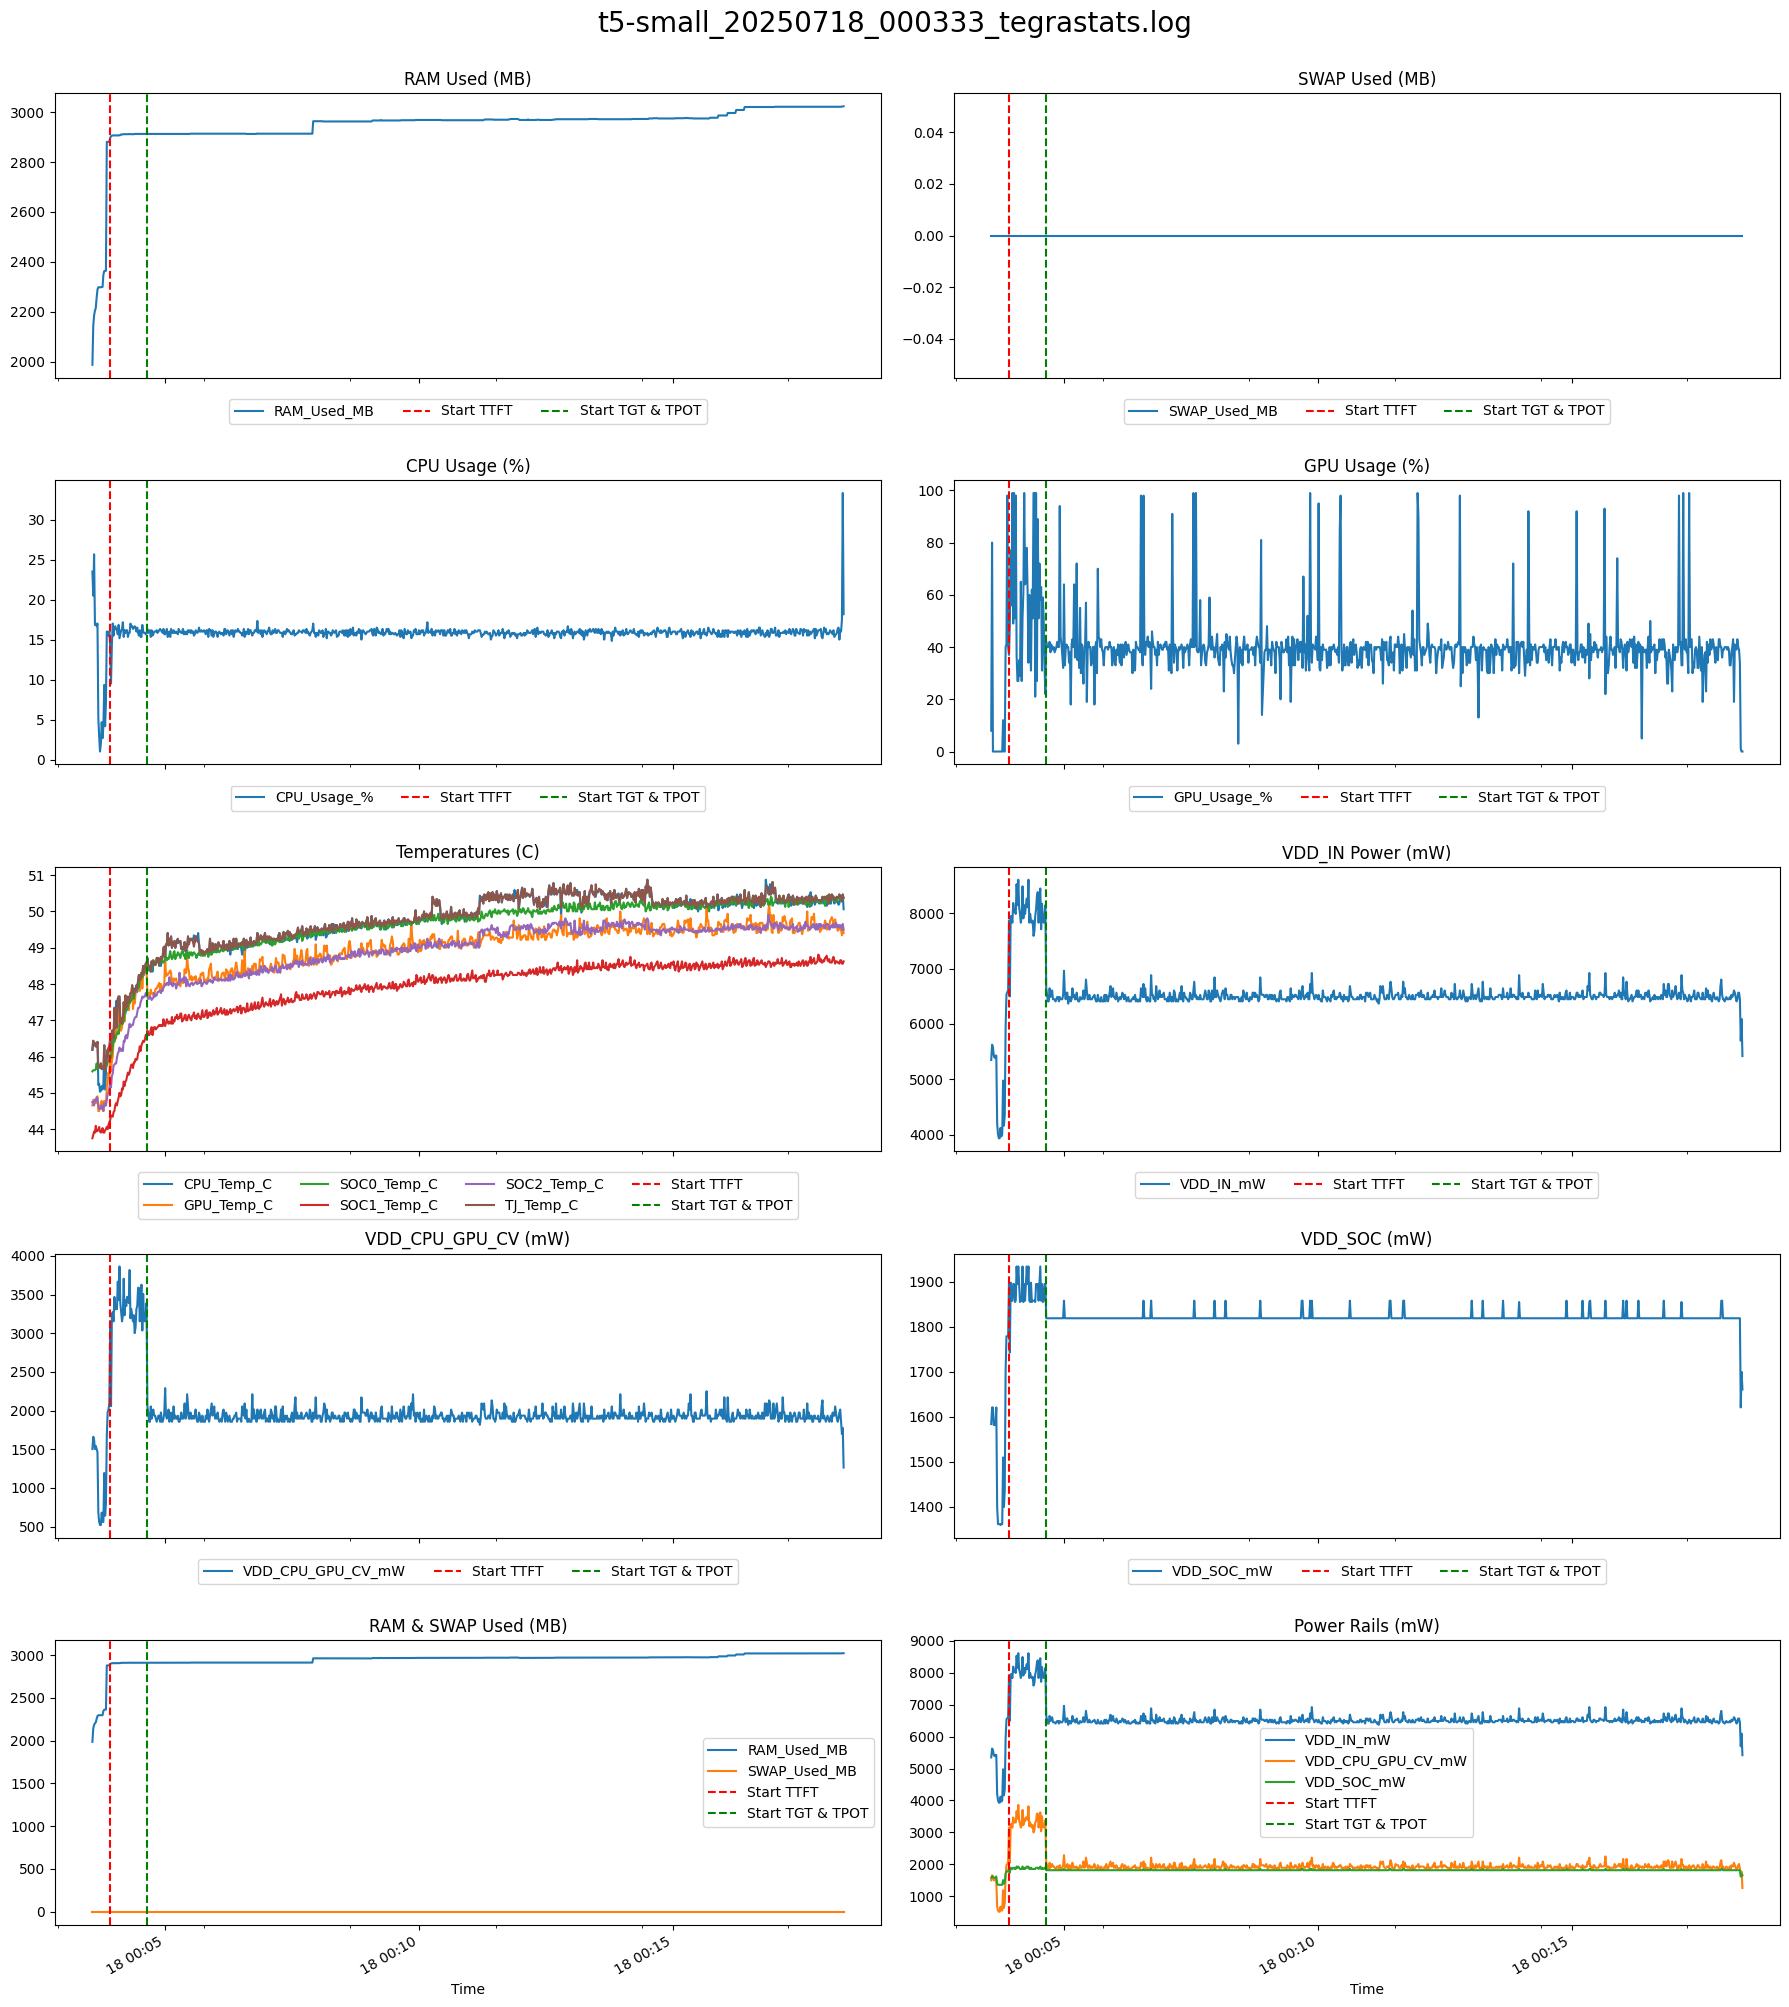

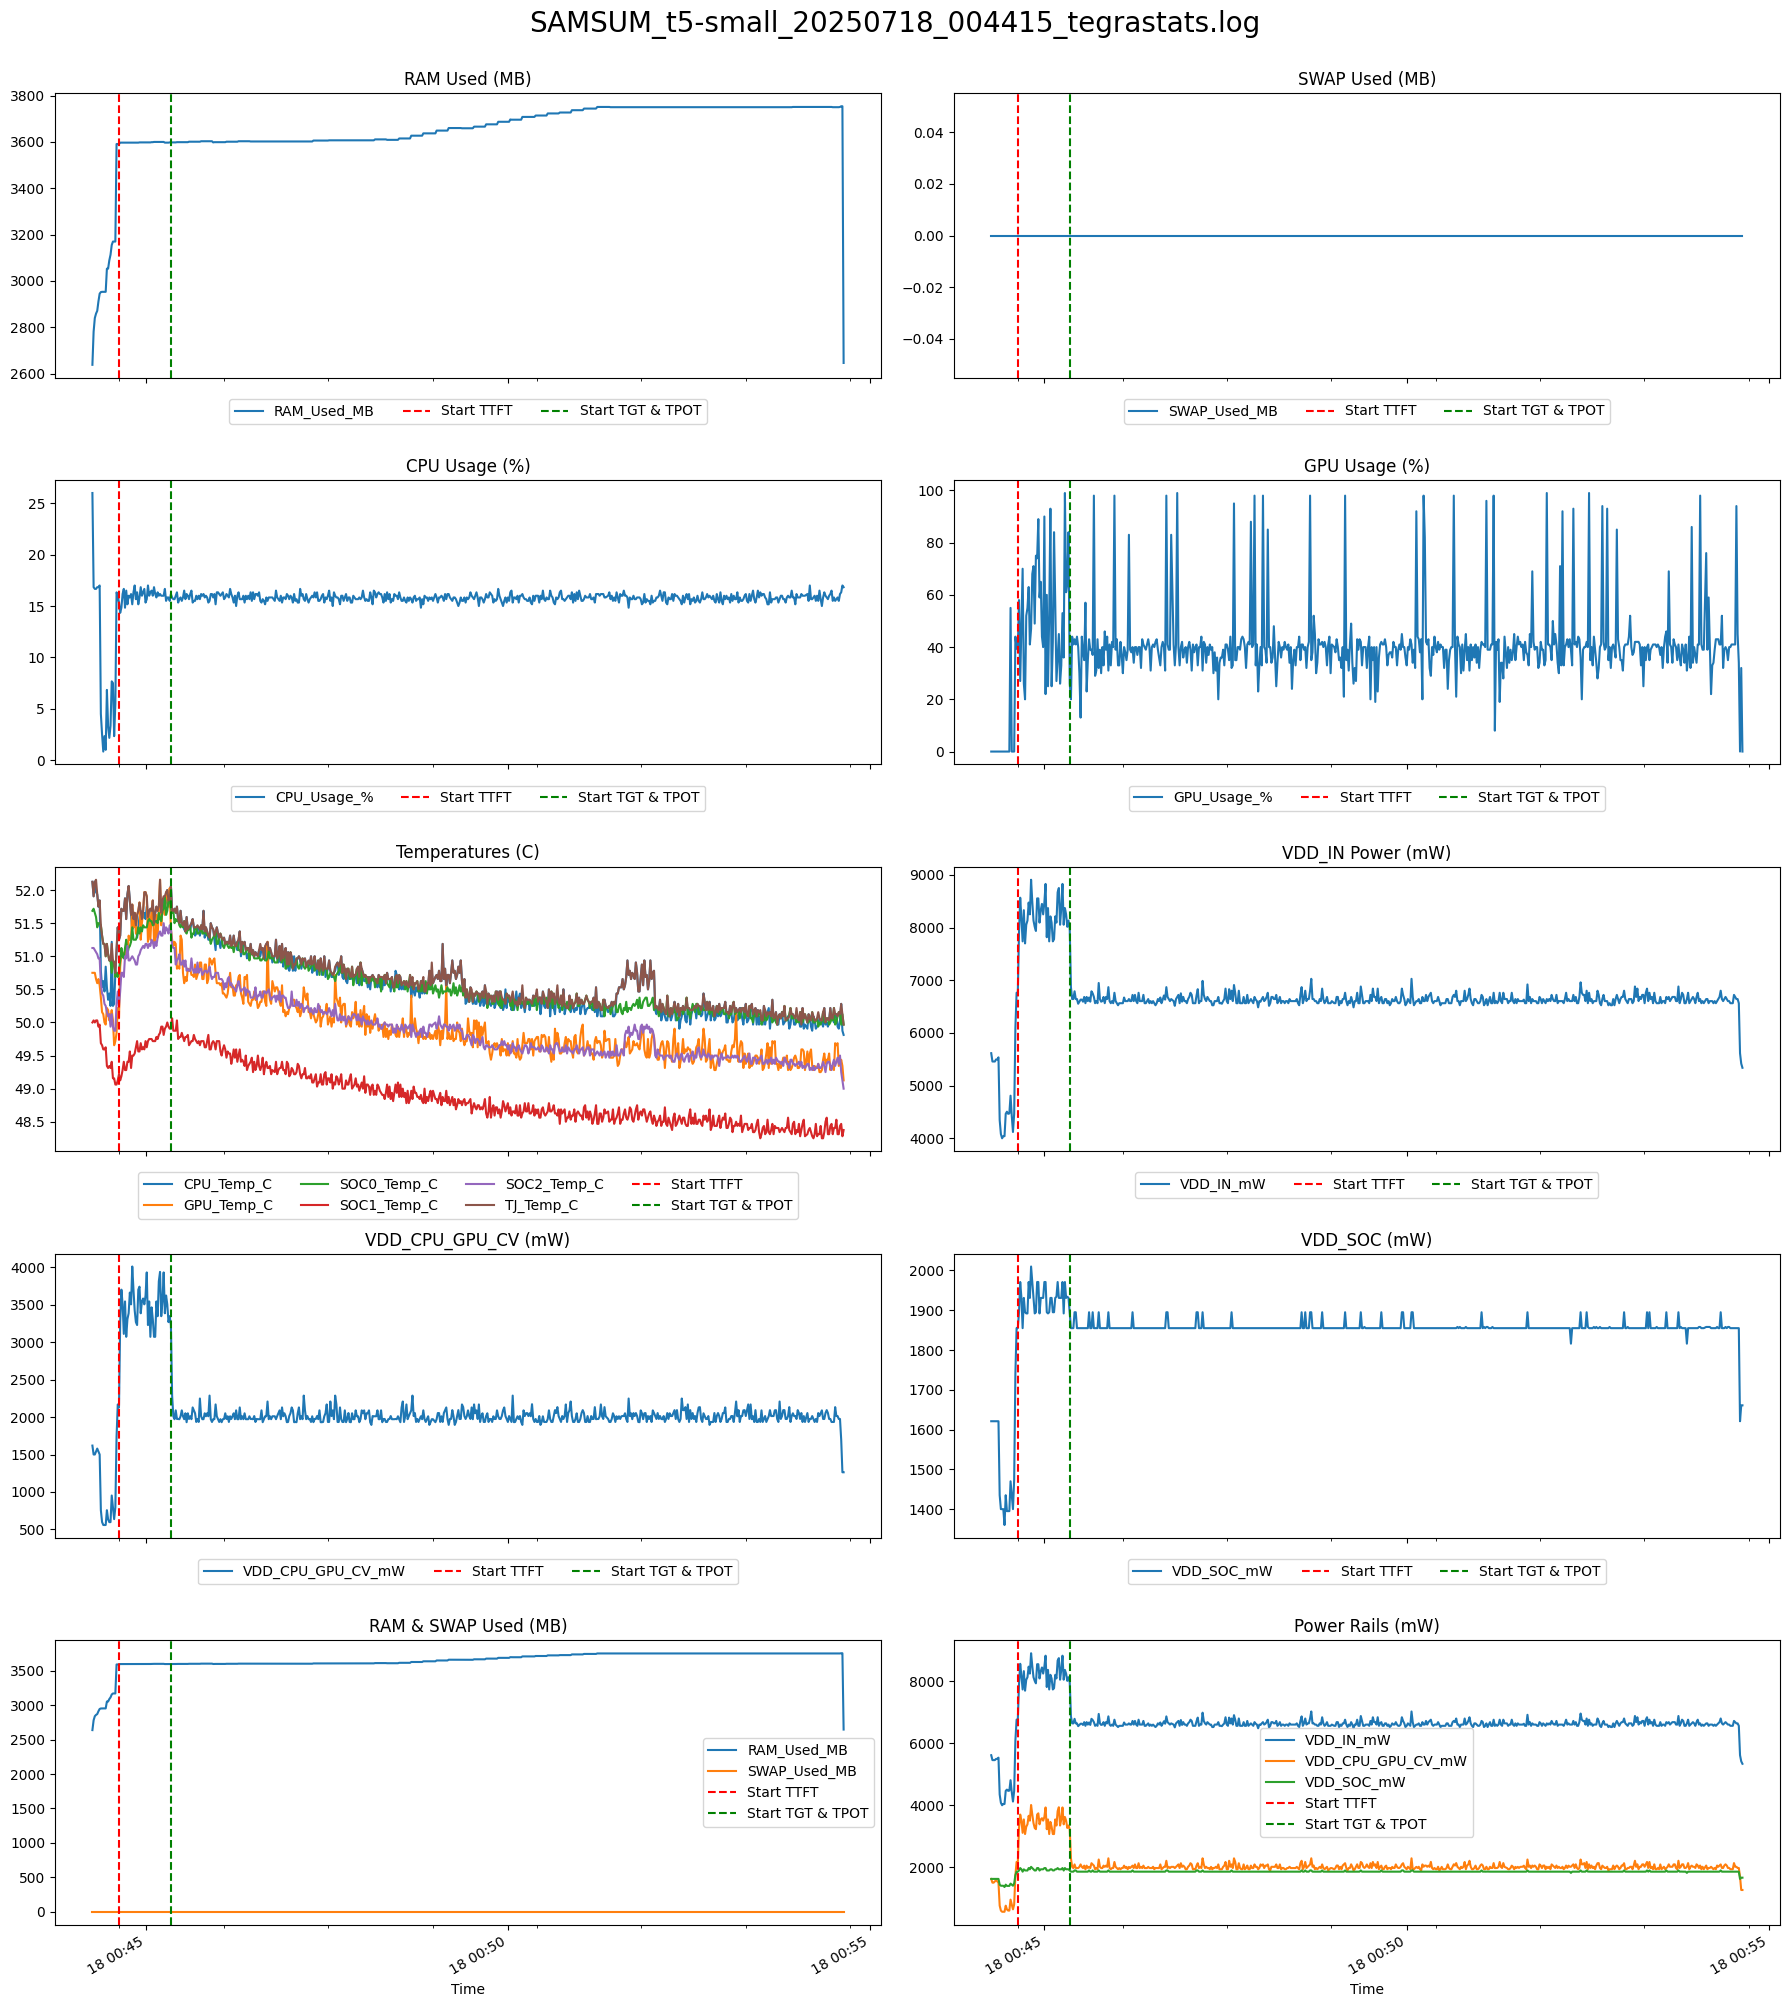

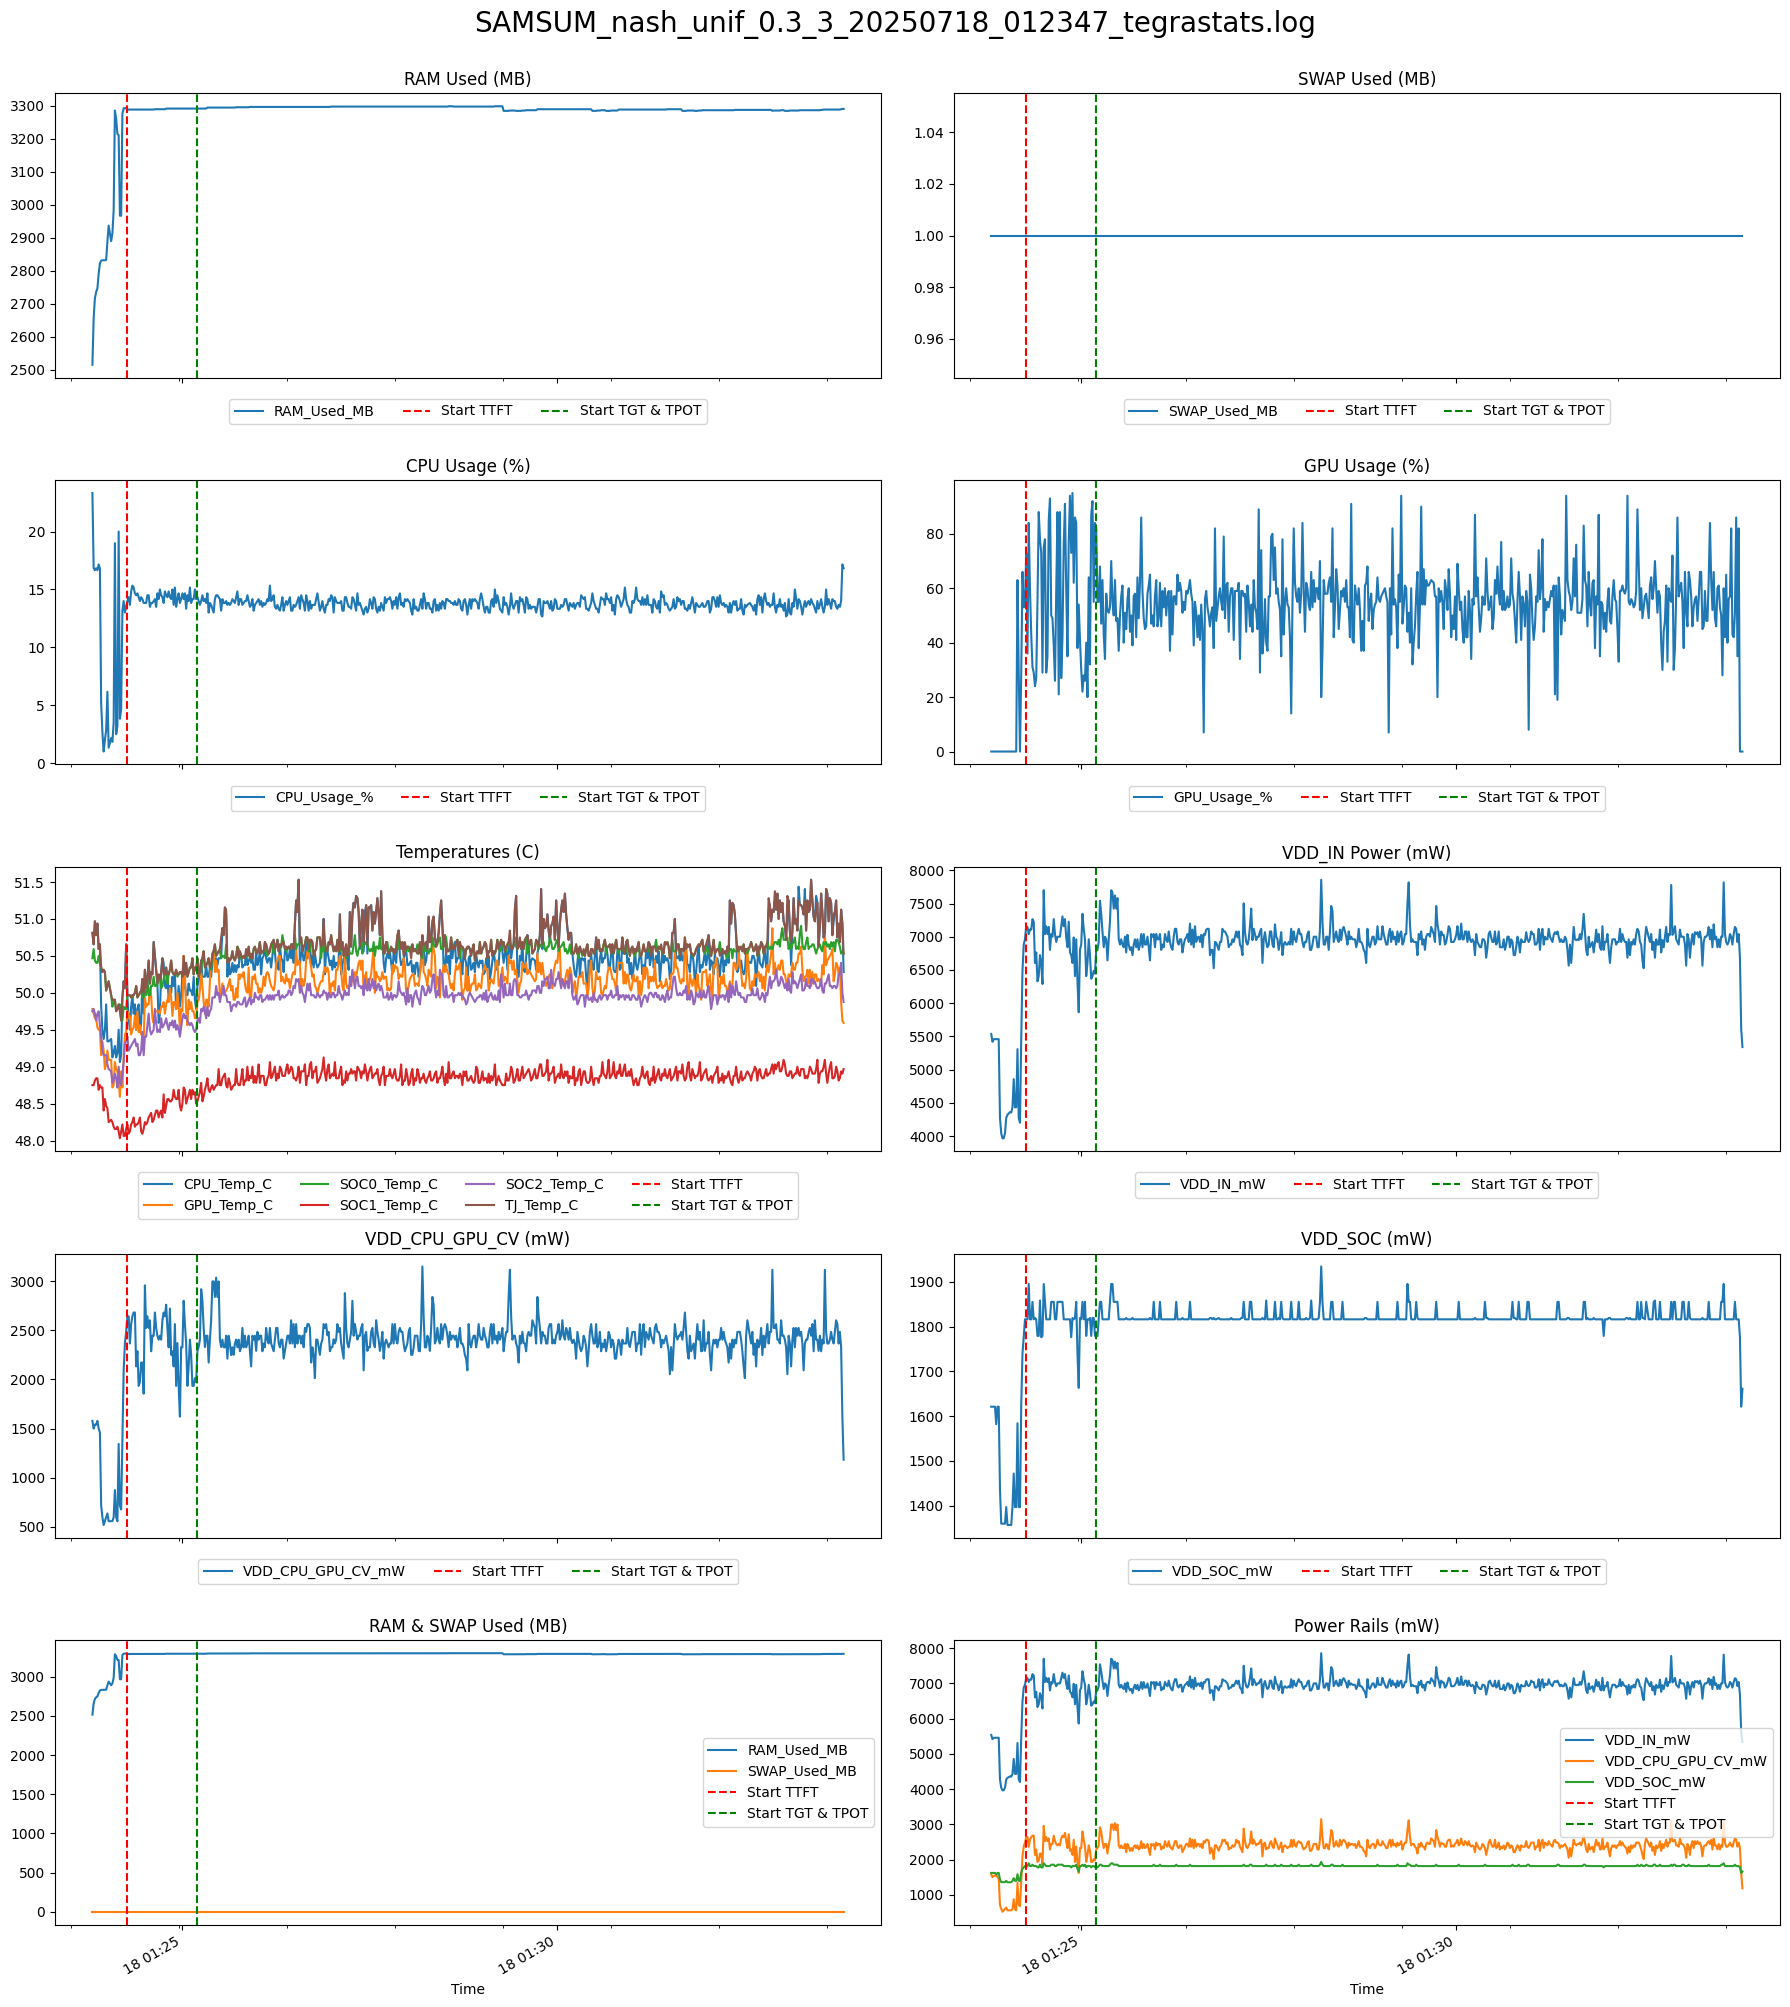

In [50]:
for i, logfile in enumerate(tegrastats_paths):

    logfile_name = os.path.basename(logfile)
    
    vline_times = get_timestamp_from_log(terminal_paths[i])
    
    vline_labels = [
        "Start TTFT",
        "Start TGT & TPOT"
    ]


    vline_times = [pd.to_datetime(t) for t in vline_times]

    df = tegrastats_log_to_df(logfile)

    fig, axs = plt.subplots(5, 2, figsize=(18, 20), sharex=True)
    df.plot(x="Time", y="RAM_Used_MB", ax=axs[0,0], title="RAM Used (MB)")
    df.plot(x="Time", y="SWAP_Used_MB", ax=axs[0,1], title="SWAP Used (MB)")
    df.plot(x="Time", y="CPU_Usage_%", ax=axs[1,0], title="CPU Usage (%)")
    df.plot(x="Time", y="GPU_Usage_%", ax=axs[1,1], title="GPU Usage (%)")
    
    df.plot(x="Time", y=["CPU_Temp_C", "GPU_Temp_C", "SOC0_Temp_C", "SOC1_Temp_C", "SOC2_Temp_C", "TJ_Temp_C"], ax=axs[2,0], title="Temperatures (C)")
    # axs[2,0].axhline(22.5, color='red', linestyle='--', label='Ambient Temp (22.5C)')
    
    df.plot(x="Time", y="VDD_IN_mW", ax=axs[2,1], title="VDD_IN Power (mW)")
    df.plot(x="Time", y="VDD_CPU_GPU_CV_mW", ax=axs[3,0], title="VDD_CPU_GPU_CV (mW)")
    df.plot(x="Time", y="VDD_SOC_mW", ax=axs[3,1], title="VDD_SOC (mW)")
    df.plot(x="Time", y=["RAM_Used_MB", "SWAP_Used_MB"], ax=axs[4,0], title="RAM & SWAP Used (MB)")
    df.plot(x="Time", y=["VDD_IN_mW", "VDD_CPU_GPU_CV_mW", "VDD_SOC_mW"], ax=axs[4,1], title="Power Rails (mW)")
    
    # Add vertical lines to subplots
    for ax_row in range(4):
        for ax_col in range(2):           
            axs[ax_row, ax_col].axvline(vline_times[0], color='red', linestyle='--', label=vline_labels[0])
            axs[ax_row, ax_col].axvline(vline_times[1], color='green', linestyle='--', label=vline_labels[1])
            axs[ax_row, ax_col].legend(bbox_to_anchor=(0.5, -0.05), ncol=4, loc='upper center')
            
    
    for ax_col in range(2):  # Adjust legend for the last row
        axs[4, ax_col].axvline(vline_times[0], color='red', linestyle='--', label=vline_labels[0])
        axs[4, ax_col].axvline(vline_times[1], color='green', linestyle='--', label=vline_labels[1])
        axs[4, ax_col].legend(loc='best')
    
    fig.suptitle(f"{logfile_name}", fontsize=20, y=1.001)

    plt.tight_layout()
    plt.show()

In [51]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 598 entries, 0 to 597
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Time               598 non-null    datetime64[ns]
 1   RAM_Used_MB        598 non-null    int64         
 2   RAM_Total_MB       598 non-null    int64         
 3   SWAP_Used_MB       598 non-null    int64         
 4   SWAP_Total_MB      598 non-null    int64         
 5   CPU_Usage_%        598 non-null    float64       
 6   GPU_Usage_%        598 non-null    int64         
 7   CPU_Temp_C         598 non-null    float64       
 8   GPU_Temp_C         598 non-null    float64       
 9   SOC0_Temp_C        598 non-null    float64       
 10  SOC1_Temp_C        598 non-null    float64       
 11  SOC2_Temp_C        598 non-null    float64       
 12  TJ_Temp_C          598 non-null    float64       
 13  VDD_IN_mW          598 non-null    int64         
 14  VDD_CPU_GP

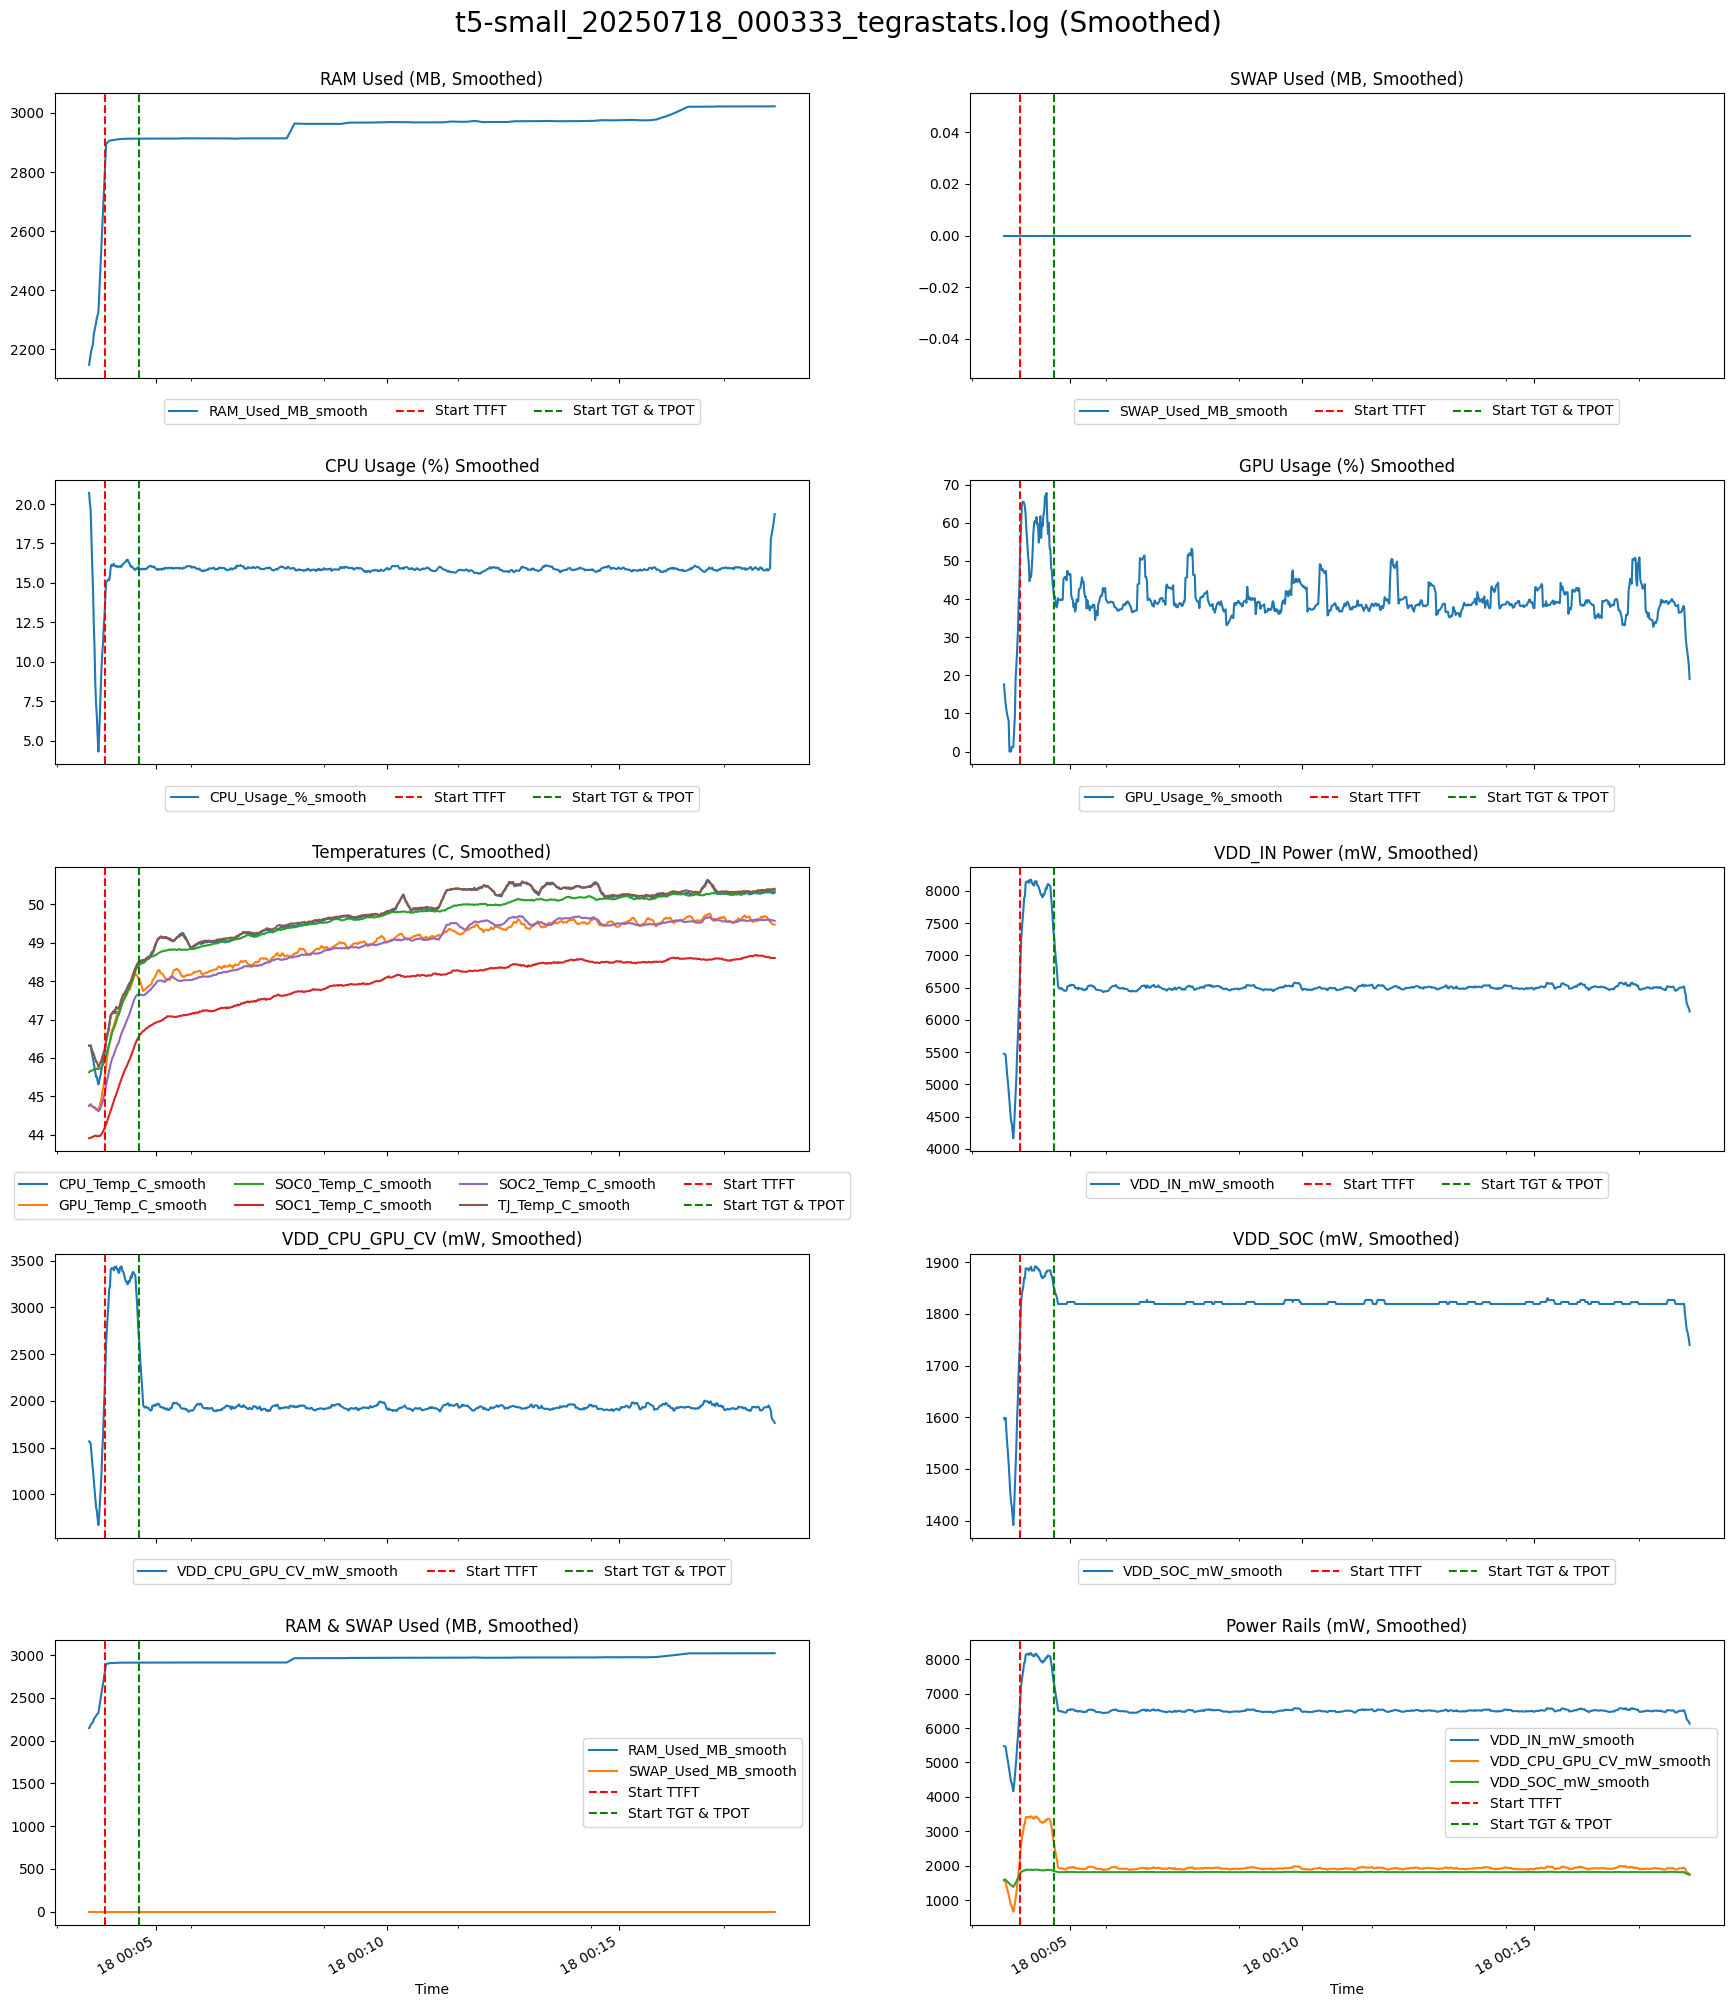

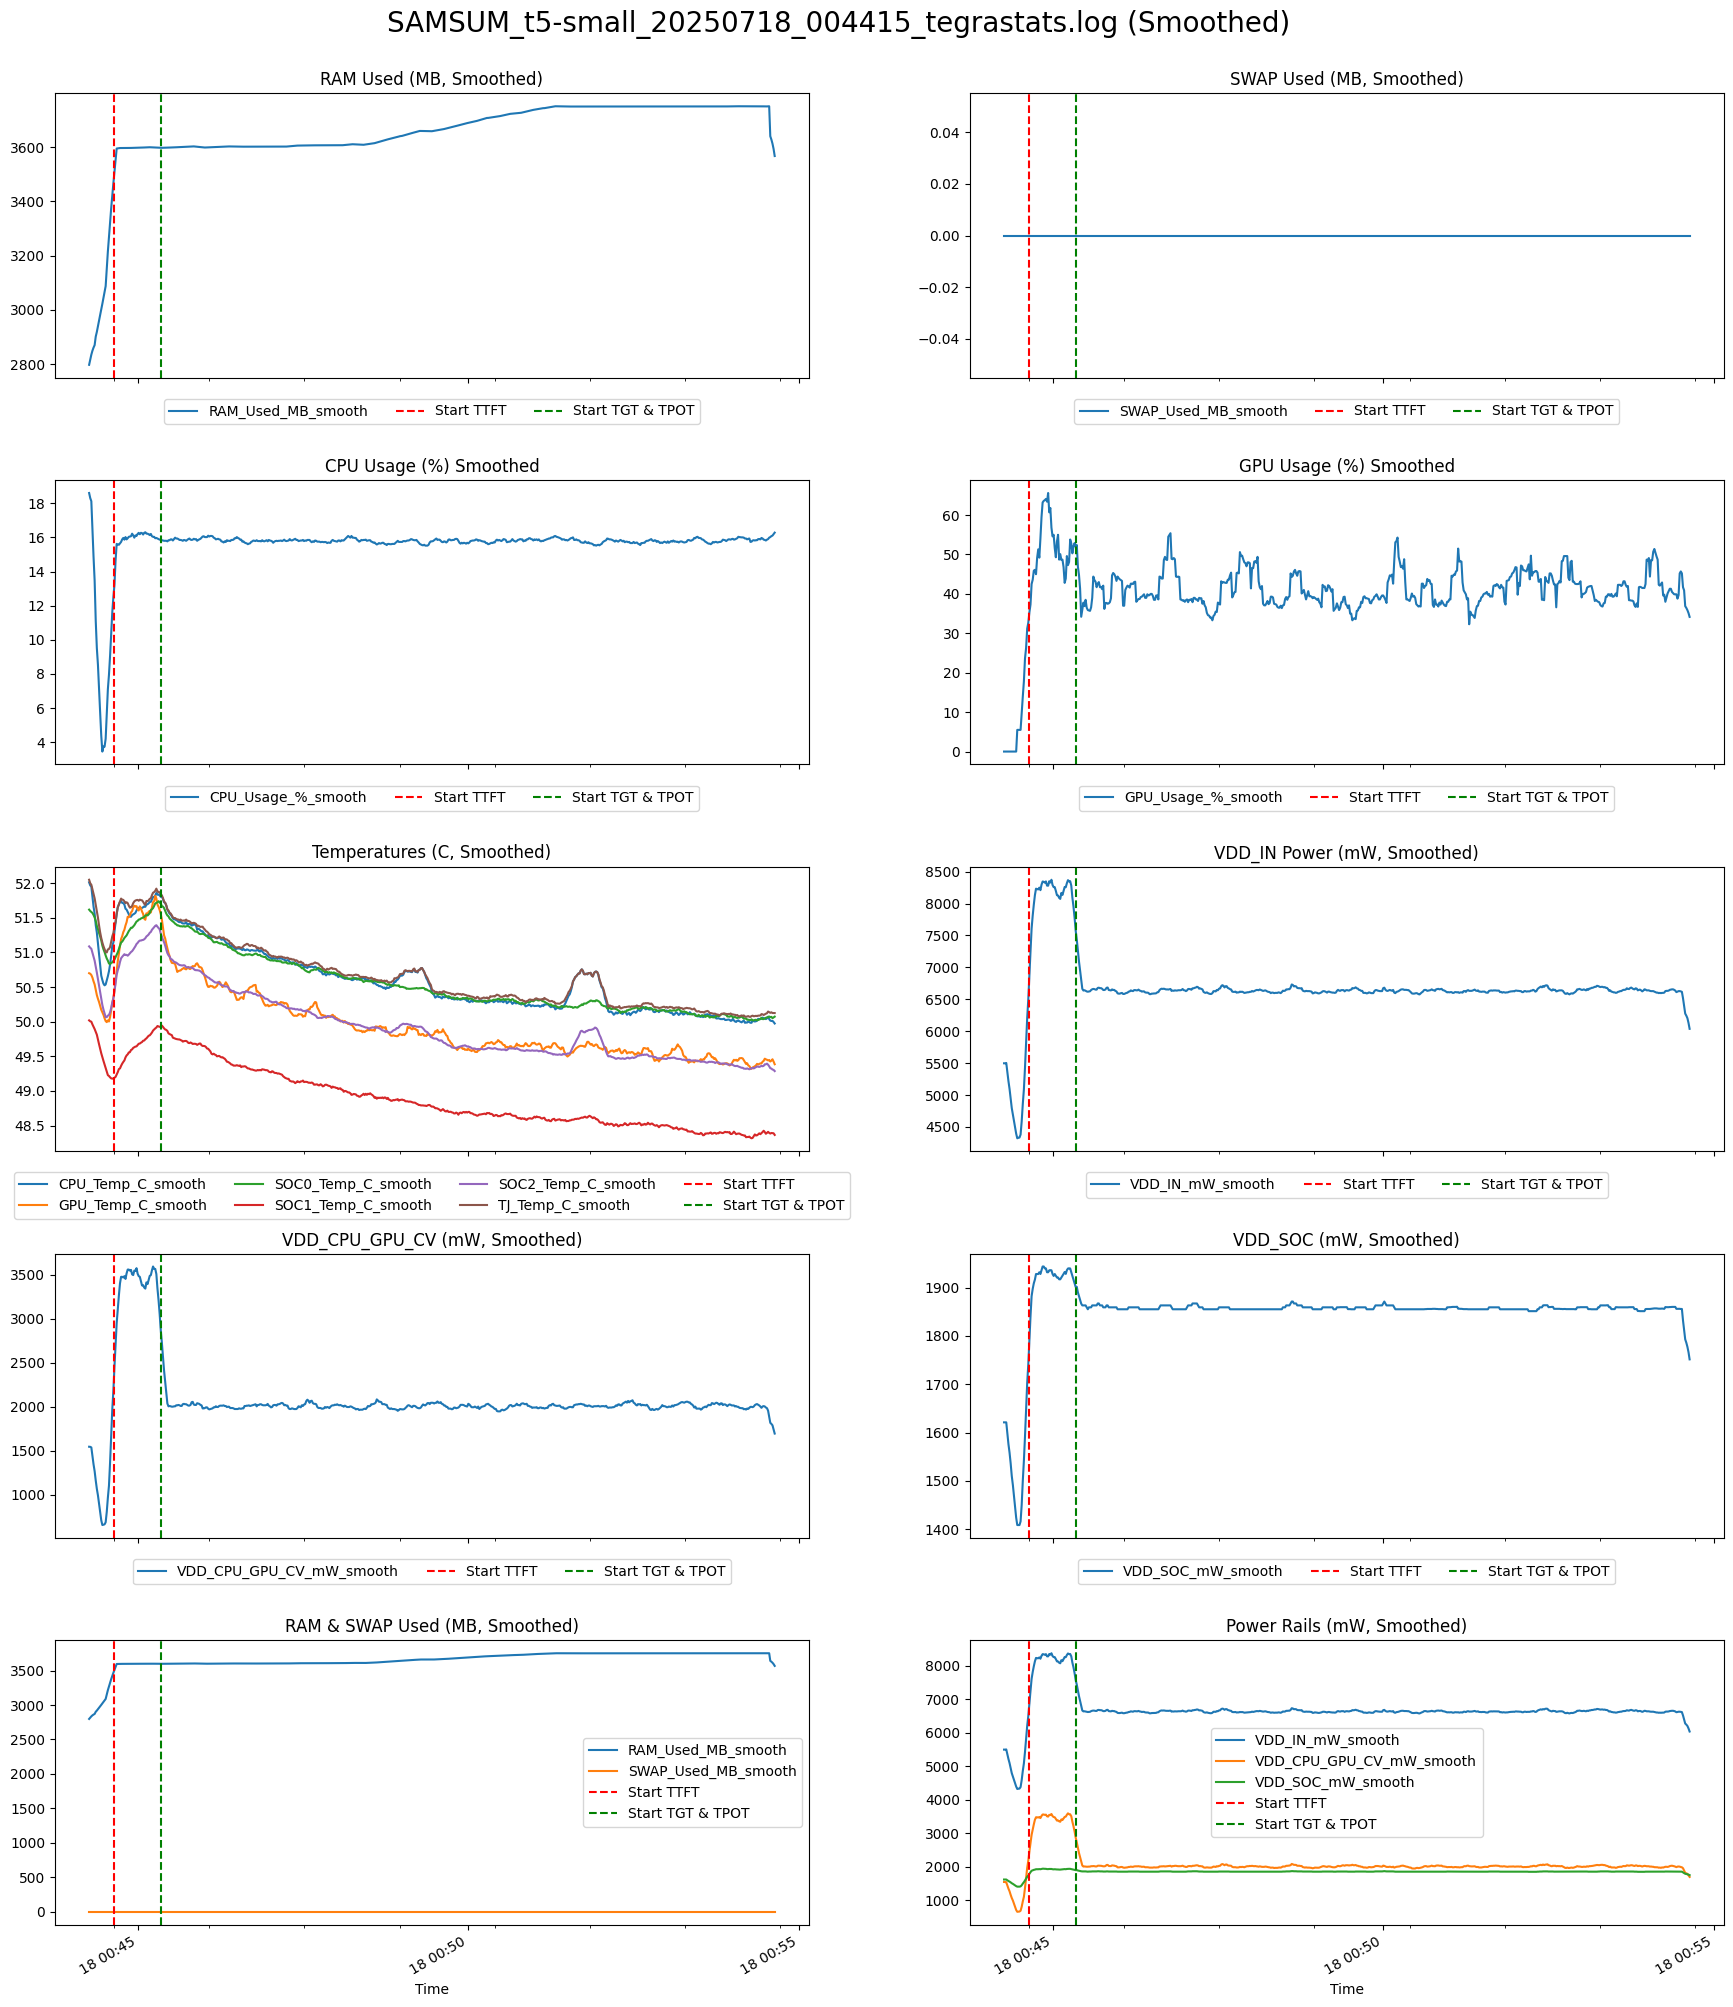

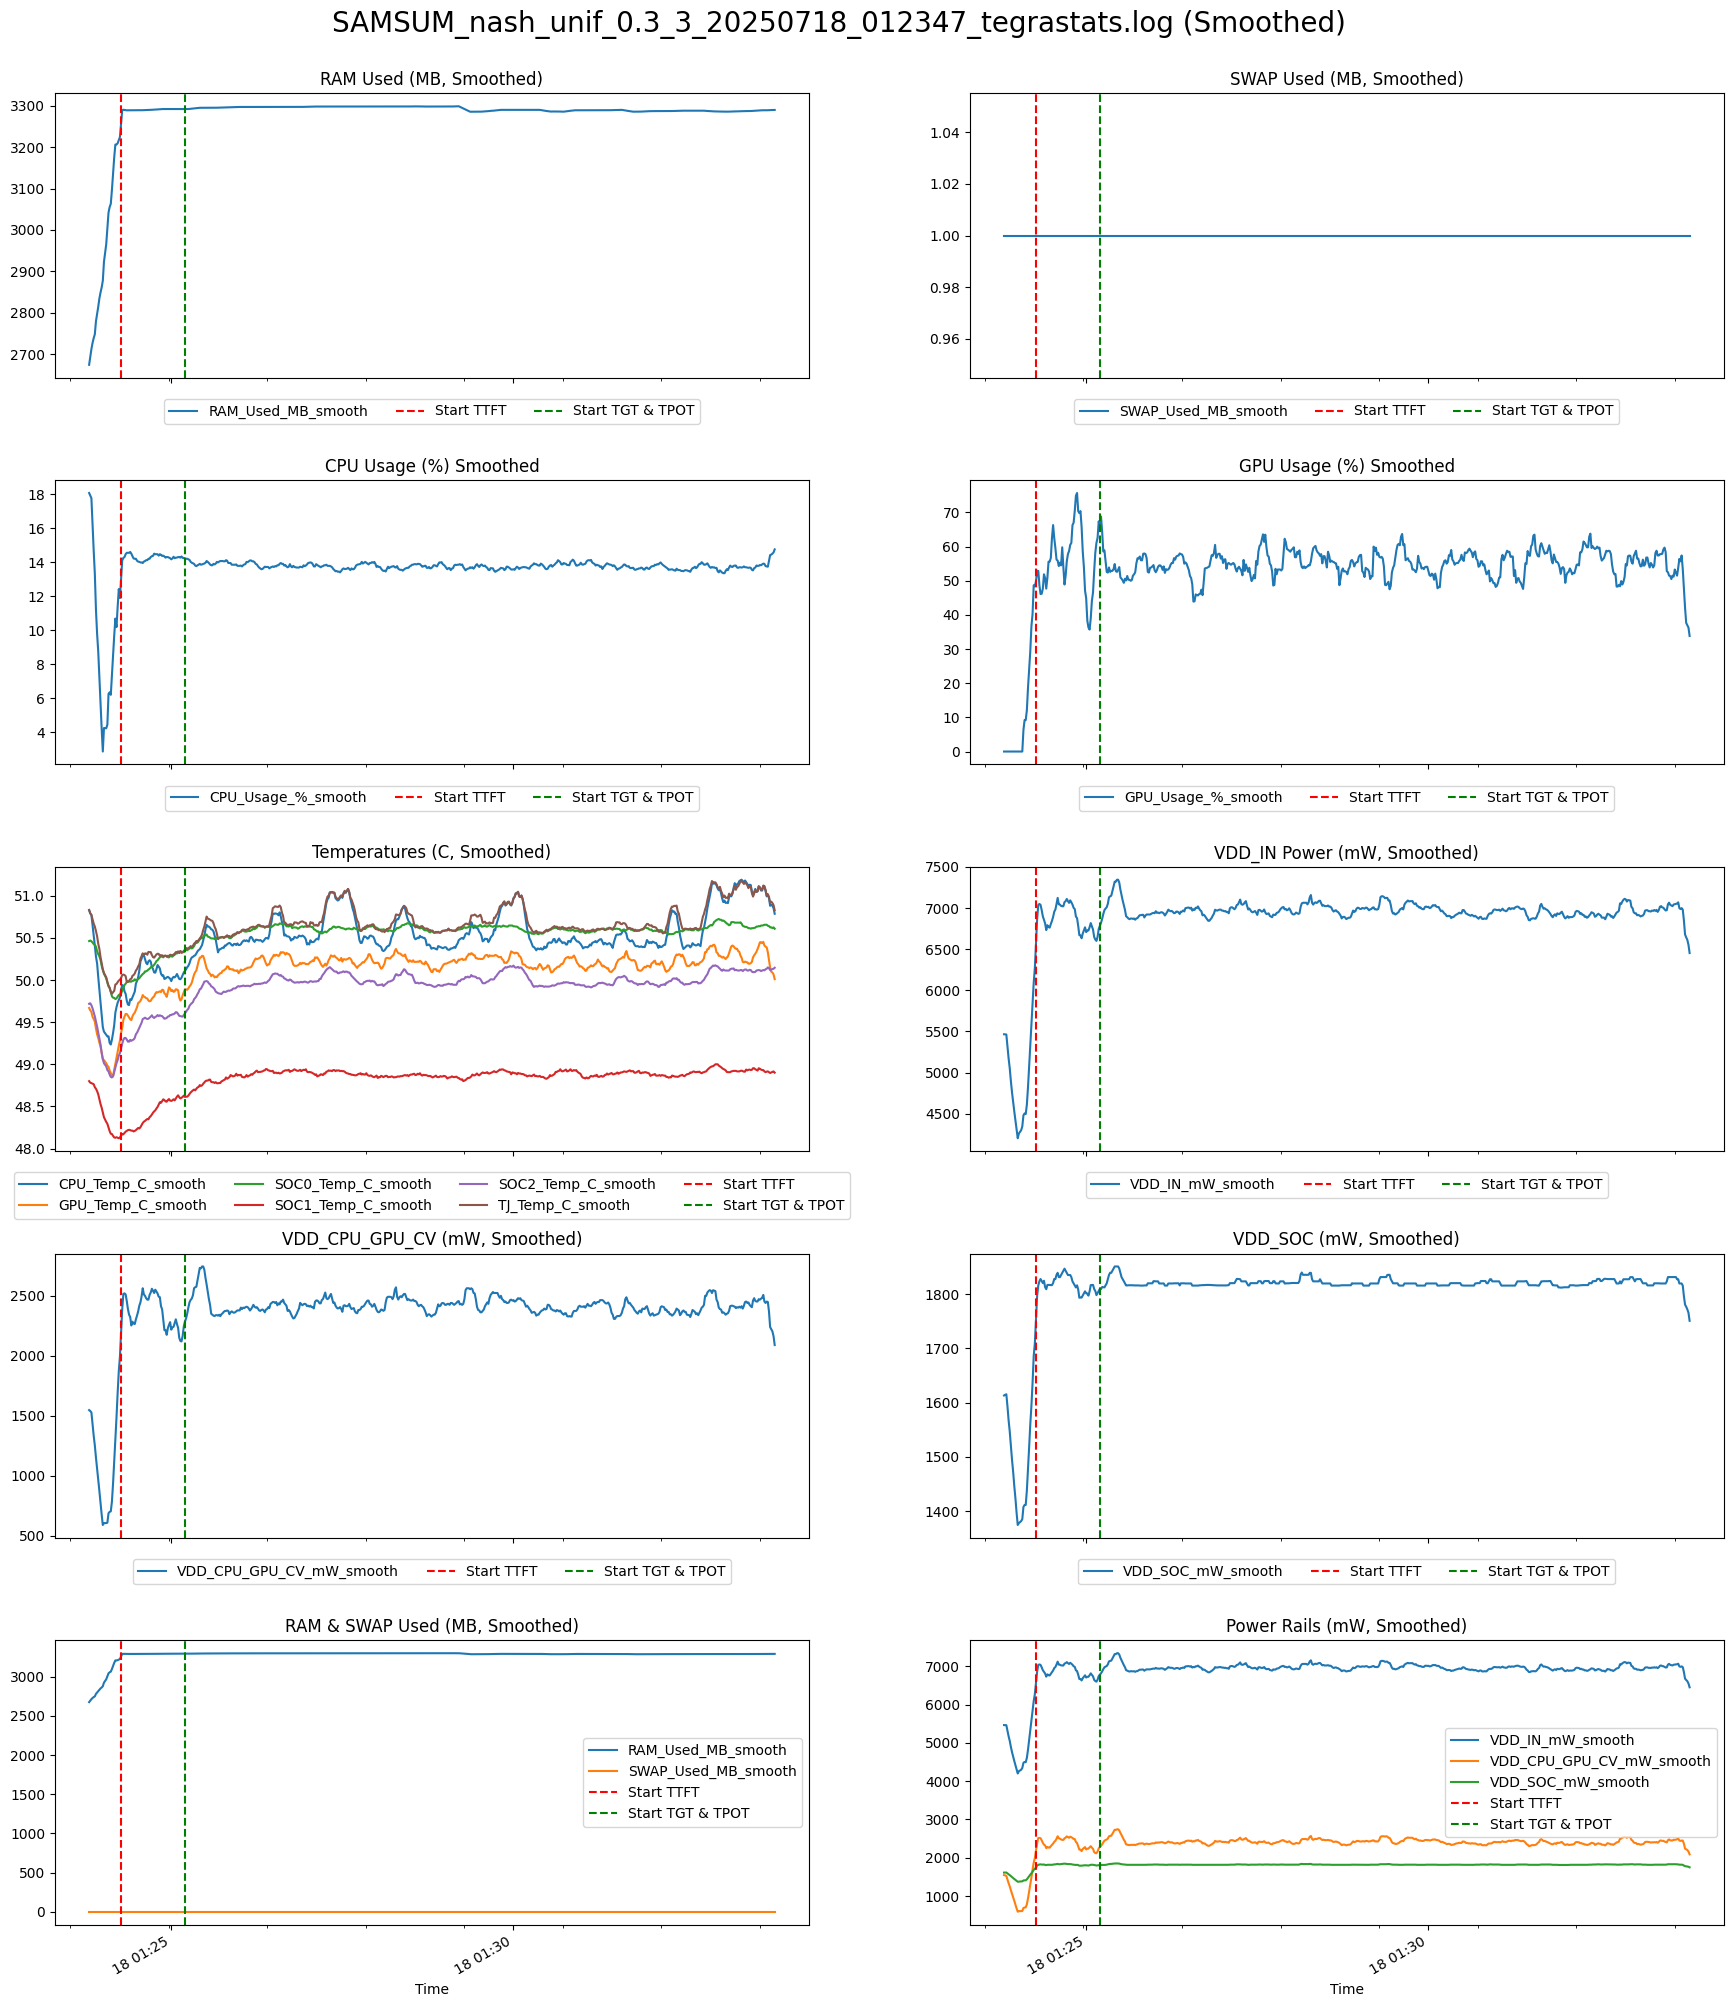

In [52]:
for i, logfile in enumerate(tegrastats_paths):

    logfile_name = os.path.basename(logfile)
    
    vline_times = get_timestamp_from_log(terminal_paths[i])
    
    vline_labels = [
        "Start TTFT",
        "Start TGT & TPOT"
    ]

    vline_times = [pd.to_datetime(t) for t in vline_times]

    df = tegrastats_log_to_df(logfile)
    
    smooth_cols = [
        "RAM_Used_MB", "SWAP_Used_MB", "CPU_Usage_%", "GPU_Usage_%",
        "CPU_Temp_C", "GPU_Temp_C", "SOC0_Temp_C", "SOC1_Temp_C", "SOC2_Temp_C", "TJ_Temp_C",
        "VDD_IN_mW", "VDD_CPU_GPU_CV_mW", "VDD_SOC_mW"
    ]
    window = 10  # Adjust window size as needed
    for col in smooth_cols:
        df[f"{col}_smooth"] = df[col].rolling(window=window, min_periods=1, center=True).mean()

    fig, axs = plt.subplots(5, 2, figsize=(18, 20), sharex=True)
    df.plot(x="Time", y="RAM_Used_MB_smooth", ax=axs[0,0], title="RAM Used (MB, Smoothed)")
    df.plot(x="Time", y="SWAP_Used_MB_smooth", ax=axs[0,1], title="SWAP Used (MB, Smoothed)")
    df.plot(x="Time", y="CPU_Usage_%_smooth", ax=axs[1,0], title="CPU Usage (%) Smoothed")
    df.plot(x="Time", y="GPU_Usage_%_smooth", ax=axs[1,1], title="GPU Usage (%) Smoothed")
    
    df.plot(
        x="Time",
        y=[f"{c}_smooth" for c in ["CPU_Temp_C", "GPU_Temp_C", "SOC0_Temp_C", "SOC1_Temp_C", "SOC2_Temp_C", "TJ_Temp_C"]],
        ax=axs[2,0], title="Temperatures (C, Smoothed)"
    )
    # axs[2,0].axhline(22.5, color='red', linestyle='--', label='Ambient Temp (22.5C)')
    
    df.plot(x="Time", y="VDD_IN_mW_smooth", ax=axs[2,1], title="VDD_IN Power (mW, Smoothed)")
    df.plot(x="Time", y="VDD_CPU_GPU_CV_mW_smooth", ax=axs[3,0], title="VDD_CPU_GPU_CV (mW, Smoothed)")
    df.plot(x="Time", y="VDD_SOC_mW_smooth", ax=axs[3,1], title="VDD_SOC (mW, Smoothed)")
    df.plot(x="Time", y=["RAM_Used_MB_smooth", "SWAP_Used_MB_smooth"], ax=axs[4,0], title="RAM & SWAP Used (MB, Smoothed)")
    df.plot(
        x="Time",
        y=["VDD_IN_mW_smooth", "VDD_CPU_GPU_CV_mW_smooth", "VDD_SOC_mW_smooth"],
        ax=axs[4,1], title="Power Rails (mW, Smoothed)"
    )
    
    # Add vertical lines to subplots
    for ax_row in range(4):
        for ax_col in range(2):           
            axs[ax_row, ax_col].axvline(vline_times[0], color='red', linestyle='--', label=vline_labels[0])
            axs[ax_row, ax_col].axvline(vline_times[1], color='green', linestyle='--', label=vline_labels[1])
            axs[ax_row, ax_col].legend(bbox_to_anchor=(0.5, -0.05), ncol=4, loc='upper center')
            
    
    for ax_col in range(2):  # Adjust legend for the last row
        axs[4, ax_col].axvline(vline_times[0], color='red', linestyle='--', label=vline_labels[0])
        axs[4, ax_col].axvline(vline_times[1], color='green', linestyle='--', label=vline_labels[1])
        axs[4, ax_col].legend(loc='best')
    
    fig.suptitle(f"{logfile_name} (Smoothed)", fontsize=20, y=1.001)

    plt.tight_layout()
    plt.show()

## Summary

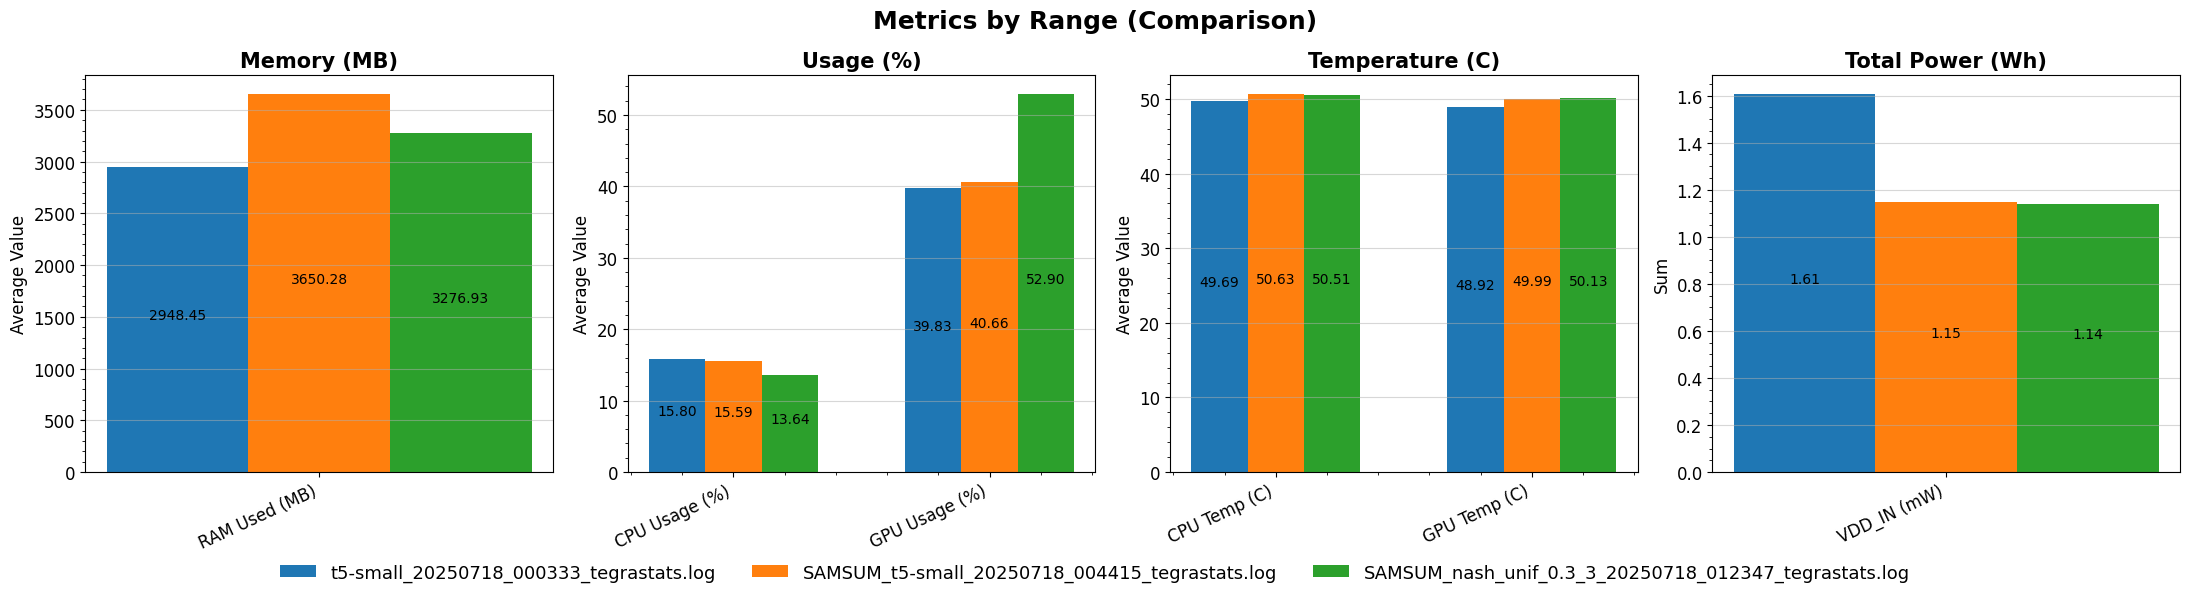

In [53]:
logfile_names = [os.path.basename(f) for f in tegrastats_paths]
dfs = [tegrastats_log_to_df(f) for f in tegrastats_paths]

# Define metrics and groups
metrics_groups = {
    "Memory (MB)": [
        ("RAM Used (MB)", "RAM_Used_MB"),
        # ("SWAP Used (MB)", "SWAP_Used_MB"),
    ],
    "Usage (%)": [
        ("CPU Usage (%)", "CPU_Usage_%"),
        ("GPU Usage (%)", "GPU_Usage_%"),
    ],
    "Temperature (C)": [
        ("CPU Temp (C)", "CPU_Temp_C"),
        ("GPU Temp (C)", "GPU_Temp_C"),
        # ("SOC0 Temp (C)", "SOC0_Temp_C"),
        # ("SOC1 Temp (C)", "SOC1_Temp_C"),
        # ("SOC2 Temp (C)", "SOC2_Temp_C"),
        # ("TJ Temp (C)", "TJ_Temp_C"),
    ],
    "Power (mW)": [
        ("VDD_IN (mW)", "VDD_IN_mW"),
        # ("VDD_CPU_GPU_CV (mW)", "VDD_CPU_GPU_CV_mW"),
        # ("VDD_SOC (mW)", "VDD_SOC_mW"),
    ]
}

fig, axs = plt.subplots(1, 4, figsize=(22, 6))
for ax, (group, items) in zip(axs, metrics_groups.items()):
    labels = [label for label, _ in items]
    n_metrics = len(items)
    x = np.arange(n_metrics)
    bar_width = 0.22

    # Gather values for each log file
    values = []
    for df in dfs:
        if group == "Power (mW)":
            # Convert mW to Wh: sum(mW) * (interval in seconds) / 1000 / 3600
            # Estimate interval in seconds
            time_deltas = df["Time"].diff().dt.total_seconds().dropna()
            interval = time_deltas.mode()[0] if not time_deltas.empty else 1.0
            n_samples = df.shape[0]
            total_seconds = interval * n_samples
            # For each power rail, compute Wh
            values.append([
                df[col].sum() * interval / 1000 / 3600 for _, col in items
            ])
        else:
            # Use mean for all other metrics
            values.append([df[col].mean() for _, col in items])

    # Plot bars for each log file
    for i, (vals, name) in enumerate(zip(values, logfile_names)):
        bars = ax.bar(x + i*bar_width, vals, width=bar_width, label=name)

    ax.set_title('Total Power (Wh)' if group == "Power (mW)" else group, fontsize=15, fontweight='bold')
    ax.set_xticks(x + bar_width)
    ax.set_xticklabels(labels, rotation=25, ha='right', fontsize=12)
    ax.set_ylabel('Sum' if group == "Power (mW)" else 'Average Value', fontsize=12)
    
    ax.yaxis.set_minor_locator(AutoMinorLocator())
    ax.tick_params(axis='y', labelsize=12)
    ax.minorticks_on()
    ax.grid(which='major', axis='y', linestyle='-', alpha=0.5)
    
    for container in ax.containers:
        ax.bar_label(container, fmt='%.2f', label_type='center', fontsize=10, padding=3, color='black')

# Only show one legend at the bottom center
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc="lower center", ncol=len(logfile_names), fontsize=13, frameon=False)
fig.suptitle('Metrics by Range (Comparison)', fontsize=18, fontweight='bold')
plt.tight_layout(rect=[0, 0.05, 1, 1])  # leave space for legend
plt.show()

# ROUGE Score

In [54]:
def extract_metrics_from_terminal_log(logfile):
    """
    Extract ROUGE and latency metrics from a terminal log file.
    Returns: (rouge1, rouge2, rougeL, rougeLsum, avg_ttft, avg_tgt, avg_tpot, avg_tps, avg_gen_len)
    """
    with open(logfile, "r") as f:
        text = f.read()

    # Extract ROUGE scores
    rouge1 = float(re.search(r'rouge1:\s*([0-9.]+)', text).group(1))
    rouge2 = float(re.search(r'rouge2:\s*([0-9.]+)', text).group(1))
    rougeL = float(re.search(r'rougeL:\s*([0-9.]+)', text).group(1))
    rougeLsum = float(re.search(r'rougeLsum:\s*([0-9.]+)', text).group(1))

    return rouge1, rouge2, rougeL, rougeLsum

In [55]:
metric_names = [
    "ROUGE-1", "ROUGE-2", "ROUGE-L", "ROUGE-Lsum"
]

terminal_logfile_names = [os.path.basename(f) for f in terminal_paths]

all_metrics = []
for logfile in terminal_paths:
    all_metrics.append(extract_metrics_from_terminal_log(logfile))

rouge_df = pd.DataFrame(all_metrics, columns=metric_names, index=terminal_logfile_names).T
rouge_df.index.name = "Metric"
display(rouge_df)

,t5-small_20250718_000333_terminal.log,SAMSUM_t5-small_20250718_004415_terminal.log,SAMSUM_nash_unif_0.3_3_20250718_012347_terminal.log
Metric,,,
ROUGE-1,0.2378,0.4699,0.4600
ROUGE-2,0.0617,0.2221,0.2180
ROUGE-L,0.1899,0.3838,0.3818
ROUGE-Lsum,0.1900,0.3835,0.3815


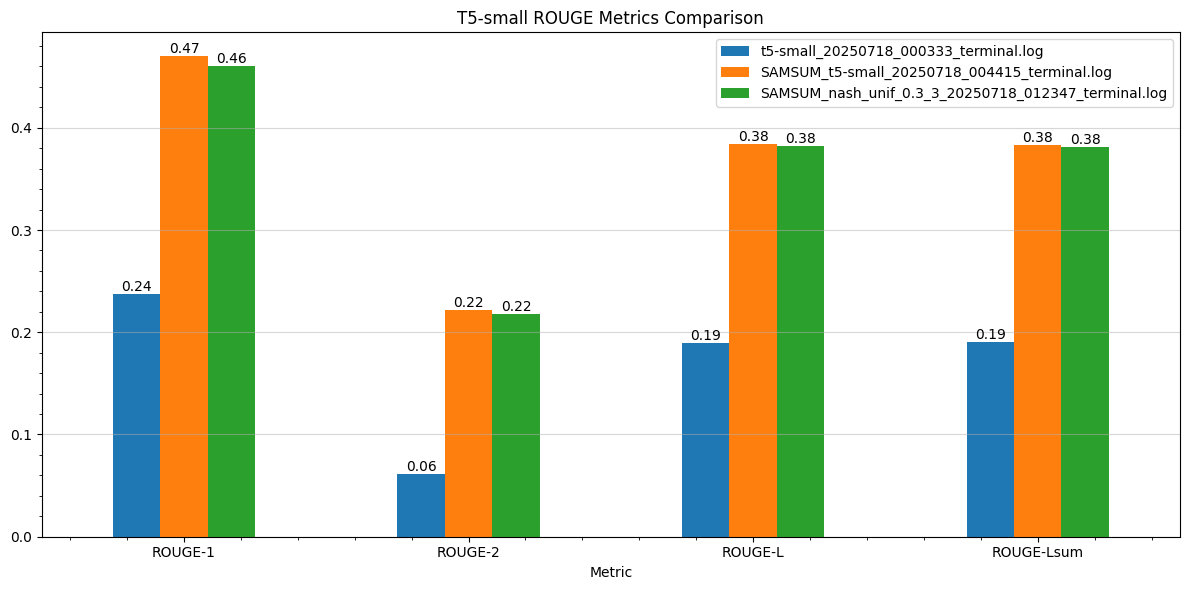

In [57]:
ax = rouge_df.plot(kind='bar', figsize=(12, 6), title='T5-small ROUGE Metrics Comparison')
ax.minorticks_on()
ax.grid(which='major', axis='y', linestyle='-', alpha=0.5)
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f')

plt.xticks(rotation=0)
plt.tight_layout()
plt.show()